In [1]:
import os
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic") # the root folder of dynapseReservoir and DYNAPSETools

import numpy as np
import matplotlib.pyplot as plt


from dynapseReservoir.networks.inputsParameters import in_5_0_P
from dynapseReservoir.networks.reservoirsParameters import generalNetP 
import DYNAPSETools.dynapseSpikesGenerator as DSG




# Book keeping the neuron positions

In [2]:
in_5_0_P["isiBase"]

900

In [3]:
np.random.seed(in_5_0_P["seed"])

plt.close("all")

#======================  Create events
# The trigger event that marks the start of the experiment
startTrigger = DSG.InputPattern(name = "startTrigger", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inStartTriggerPos"]   
# In this case, U4C0N16, the source address in the .txt file should be 1039. This is because N16 => 10000, C0 =>00, U04 => 1111 , 
# and the decimal of 10000001111 is 1039.


startTrigger.single_event(virtualSourceCoreId = C,
                          neuronAddress = N,
                          coreDest = in_5_0_P["coreDest"], # (= 15, means to all cores 0,1,2,3)
                         firePeriod = in_5_0_P["startDelay"])  



# First classification
onesClassification = DSG.InputPattern(name = "onesClassification", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inTargetEncodingPos"]
onesClassification.single_event(virtualSourceCoreId = C,
                                neuronAddress = N,
                                coreDest = in_5_0_P["coreDest"],
                                firePeriod = in_5_0_P["safeDelay"])

# In this case, U4C0N1, the source address in the .txt file should be 79. This is because N1 => 1, C0 =>00, U04 => 1111 , 
# and the decimal of 1001111 is 79.

In [6]:
N

1

In [46]:

# Out neuron 2 classification
twoClassification = DSG.InputPattern(name = "twoClassification", isiBase = in_5_0_P["isiBase"])
N = N + 1
twoClassification.single_event(virtualSourceCoreId = C,
                                neuronAddress = N,
                                coreDest = in_5_0_P["coreDest"],
                                firePeriod = in_5_0_P["safeDelay"])


# The end of stimulus
endStimulus = DSG.InputPattern(name = "endStimulus", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inEndStimulusPos"]
endStimulus.single_event(virtualSourceCoreId = C,
                         neuronAddress = N,
                         coreDest = in_5_0_P["coreDest"],
                         firePeriod = in_5_0_P["safeDelay"])

# The end of the experiment
stopTrigger = DSG.InputPattern(name = "stopTrigger", isiBase = in_5_0_P["isiBase"])
U, C, N = generalNetP["inStopTriggerPos"]
stopTrigger.single_event(virtualSourceCoreId = C,
                         neuronAddress = N,
                         coreDest = in_5_0_P["coreDest"],
                         firePeriod = in_5_0_P["stopDelay"])


# Creating input pattern: (1) RAMP+SINE and (2) SINE

### The First Pattern: SINE + RAMP


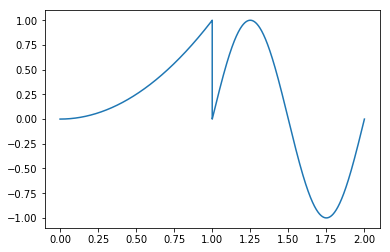

In [47]:
signal1 = DSG.InputPattern(name = "signal1", isiBase = in_5_0_P["isiBase"])

# Create the RAMP part which lasts for 1 second
tStart = tStop = 0
tStop += in_5_0_P["sig1part2Duration"]
tSig1Part2 = np.linspace(tStart, tStop, int(in_5_0_P["sigSamples"]))
ySig1Part2 = np.square(tSig1Part2 - tStart)


# Create the SINE signal part which lasts for 1 second
tStart = tStop
tStop += in_5_0_P["sig1part3Duration"]
tSig1Part3 = np.linspace(tStart, tStop, int(in_5_0_P["sigSamples"]))
ySig1Part3 = np.sin(2 * np.pi * in_5_0_P["sig1part3Freq"] * (tSig1Part3 - tStart))

# combine the ramp and the sine

tSig1 = np.ndarray.flatten(np.array([tSig1Part2, tSig1Part3]))
ySig1 = np.ndarray.flatten(np.array([ySig1Part2, ySig1Part3]))



plt.plot(tSig1, ySig1)


In [48]:

U, C, N1 = generalNetP["inCH0"]
U, C, N2 = generalNetP["inCH1"]
signal1.threshold_encoder(virtualSourceCoreId = C,
                          neuronAddressUpCH = N1,  
                          neuronAddressDwCH = N2,  
                          coreDest = in_5_0_P["coreDest"],   
                          threshold = in_5_0_P["sigThd"],    
                          t = tSig1,    
                          y = ySig1,    
                          noiseVar = in_5_0_P["sig1Jitter"],      
                          initDelay = in_5_0_P["sig1Delay"])  

In [50]:
N1

20

### The Second Pattern:  RAMP


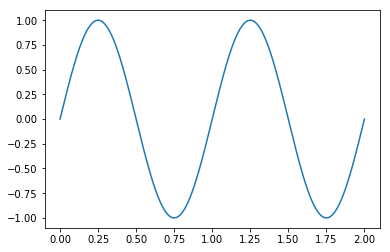

In [7]:
signal2 = DSG.InputPattern(name = "signal2", isiBase = in_5_0_P["isiBase"])
tSig2 = np.linspace(0, in_5_0_P["sig2Duration"], int(in_5_0_P["sigSamples"]))
ySig2 = np.sin(2 * np.pi * in_5_0_P["sig2Freq"] * tSig2)

U, C, N1 = generalNetP["inCH0"]
U, C, N2 = generalNetP["inCH1"]
signal2.threshold_encoder(virtualSourceCoreId = C,
                          neuronAddressUpCH = N1,
                          neuronAddressDwCH = N2,
                          coreDest = in_5_0_P["coreDest"],
                          threshold = in_5_0_P["sigThd"],
                          t = tSig2,
                          y = ySig2,
                          noiseVar = in_5_0_P["sig2Jitter"],
                          initDelay = in_5_0_P["sig2Delay"])

plt.plot(tSig2, ySig2)


In [11]:
C

0

# Create Final Patterns

In [7]:
#======================  Create Final Patterns
finalPattern = []


# repeat the RAMP + SINE signal twice as a washout
washoutPattern1 = signal1
for i in np.arange(2):
    finalPattern.append(washoutPattern1)
    
recordPattern1 = (startTrigger,
                 onesClassification,
                 signal1,
                 endStimulus,
                 stopTrigger)


# repeat the  RAMP + SINE signal 3 times (will use this part for the classification)
for i in np.arange(3):
    finalPattern.extend(recordPattern1)

    
# repeat the SINE signal twice as a washout

washoutPattern2 = signal2

for i in np.arange(2):
    finalPattern.append(washoutPattern2)
    
recordPattern2 = (startTrigger,
                 twoClassification,
                 signal2,
                 endStimulus,
                 stopTrigger)

# repeat the  SINE signal 3 times (will use this part for the classification)
for i in np.arange(3):
    finalPattern.extend(recordPattern2)
    
    


# Save and plot

In [ ]:
# ====================== Write events to output file in cAER folder
fileName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myStimulus/inClassification.txt"
DSG.write_to_file(*finalPattern, fileName = fileName)


fig, ax1, handles = DSG.plot_spikes(*recordPattern1)
delay = in_5_0_P["startDelay"] + in_5_0_P["safeDelay"] + in_5_0_P["sig1Delay"]
handle = ax1.plot((np.linspace(0, in_5_0_P["sig2Duration"], 2*int(in_5_0_P["sigSamples"])) + delay)*1e6, np.array(list(ySig1)))


fig, ax2, handles = DSG.plot_spikes(*recordPattern2)
delay = in_5_0_P["startDelay"] + in_5_0_P["safeDelay"] + in_5_0_P["sig2Delay"]
handle = ax2.plot( (np.linspace(0, tSig2[-1], len(tSig2)) + delay)*1e6, np.array(list(ySig2)))



